__NAME:__ __Venkata Subbaraju Sagi__  
__mail:__ __subbaraju.v@ou.edu__

# RANDOM FORESTS AND BOOSTING

I will be exploring Random Forests and Boosting.

### [Data set](https://www.kaggle.com/noaa/hurricane-database)
The dataset is based on cyclone weather data from NOAA.  
You can obtain the data from the server and git under datasets/cyclones.

We will be predicting whether a cyclone status is a tropical depression (TD) or not.  
Status can be the following types:  
* TD – tropical depression  
* TS – tropical storm   
* HU – hurricane intensity  
* EX – Extratropical cyclone  
* SD – subtropical depression intensity  
* SS – subtropical storm intensity  
* LO – low, neither a tropical, subtropical, nor extratropical cyclone  
* WV – Tropical Wave  
* DB – Disturbance  




In [0]:
import sys

# THESE 3 IMPORTS ARE CUSTOM .py FILES AND CAN BE FOUND 
# ON THE SERVER AND GIT
import visualize
import metrics_plots
from pipeline_components import DataSampleDropper, DataFrameSelector
from pipeline_components import DataScaler, DataLabelEncoder

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools, time
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects
import time as timelib

from math import ceil, floor
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import f1_score, mean_squared_error, roc_curve, auc
from sklearn.svm import SVR
from sklearn.externals import joblib

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

FIGW = 5
FIGH = 5
FONTSIZE = 12

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline
plt.style.use('ggplot')

In [0]:
"""
Display current working directory of this notebook. If you are using 
relative paths for your data, then it needs to be relative to the CWD.
"""
HOME_DIR = pathlib.Path.home()
pathlib.Path.cwd()

PosixPath('/home/jovyan/hw10')

# LOAD DATA

In [0]:
# TODO: set appropriately
filename = 'atlantic.csv'

cyclones_full = pd.read_csv(filename)
nRows, nCols = cyclones_full.shape
print(f'{nRows} rows and {nCols} columns')

49105 rows and 22 columns


In [0]:
""" 
not tropical depression (negative case = 0)
is tropical depression (positive case = 1)
"""
targetnames = ['notTropDepress', 'isTropDrepress']

# Determine the positve count
isTD = cyclones_full['Status'].str.contains('TD')
cyclones_full['isTD'] = isTD
npos = isTD.sum() 
nneg = nRows - npos 

# Compute the postive fraction
pos_fraction = npos / nRows
neg_fraction = 1 - pos_fraction
pos_fraction, neg_fraction

(npos, pos_fraction), (nneg, neg_fraction)

((9891, 0.20142551674982181), (39214, 0.7985744832501782))

In [0]:
""" 
Make some adjustments to the data.

For wind speed, NaNs are current represented by -999.
We will replace these with NaN.

For Latitude and Longitude, these are strings such as 
28.0W. We will replace these with numerical values where
positive directions are N and E, and negative directions 
are S and W.
"""
# Convert -999 values to NaNs. These are missing values
NaNvalue = -999
cyclones_nans = cyclones_full.replace(NaNvalue, np.nan).copy()

# Set the datatype of the categorical attributes
cate_attribs = ['Event', 'Status']
cyclones_nans[cate_attribs] = cyclones_full[cate_attribs].astype('category')

# Set the datatype of the Data attribute to datetime64[ns]
cyclones_nans['Date'] = cyclones_nans['Date'].astype('datetime64[ns]')

# Convert Latitude and Longitude into numerical values
def to_numerical(coord):
    direction = re.findall(r'[NSWE]' , coord)[0]
    num = re.match('[\d]{1,3}.[\d]{0,1}' , coord)[0]
    
    # North and East are positive directions
    if direction in ['N', 'E']:
        return np.float(num)
    return -1. * np.float(num)

cyclones_nans['Latitude'] = cyclones_nans['Latitude'].apply(to_numerical)
cyclones_nans['Longitude'] = cyclones_nans['Longitude'].apply(to_numerical)
cyclones_nans[['Latitude', 'Longitude']].head(3)

,Latitude,Longitude
0,28.0,-94.8
1,28.0,-95.4
2,28.0,-96.0


In [0]:
""" 
Display the quantitiy of NaNs for each feature
"""
cyclones_nans.isna().sum()

ID                      0
Name                    0
Date                    0
Time                    0
Event                   0
Status                  0
Latitude                0
Longitude               0
Maximum Wind            0
Minimum Pressure    30669
Low Wind NE         43184
Low Wind SE         43184
Low Wind SW         43184
Low Wind NW         43184
Moderate Wind NE    43184
Moderate Wind SE    43184
Moderate Wind SW    43184
Moderate Wind NW    43184
High Wind NE        43184
High Wind SE        43184
High Wind SW        43184
High Wind NW        43184
isTD                    0
dtype: int64

In [0]:
""" 
Display summary statistics for each feature of the dataframe
"""
cyclones_nans.describe()

,Time,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,49105.000000,49105.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,910.125975,27.044904,-65.682533,52.005091,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,671.043363,10.077880,19.687240,27.681902,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,0.000000,7.200000,-359.100000,-99.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,600.000000,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1200.000000,26.400000,-68.000000,45.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1800.000000,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,2330.000000,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


# PRE-PROCESS DATA

In [0]:
cyclones_nans.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW', 'isTD'],
      dtype='object')

In [0]:
""" 
Construct preprocessing pipeline
"""
dropped_features = ['ID', 'Name', 'Date', 'Time', 'Status', 'Event']
#selected_features = cyclones_nans.columns.drop(dropped_features)
selected_features = ['Latitude', 'Longitude', 'Low Wind SW', 'Moderate Wind NE', 
                     'Moderate Wind SE', 'High Wind NW', 'isTD']

pipe = Pipeline([
    ('FeatureSelector', DataFrameSelector(selected_features)),
    ('RowDropper', DataSampleDropper())
])

In [0]:
"""
Pre-process the data using the defined pipeline
"""
processed_data = pipe.fit_transform(cyclones_nans)
nsamples, ncols = processed_data.shape
nsamples, ncols

(5921, 7)

In [0]:
"""
Verify all NaNs removed
"""
processed_data.isna().any()

Latitude            False
Longitude           False
Low Wind SW         False
Moderate Wind NE    False
Moderate Wind SE    False
High Wind NW        False
isTD                False
dtype: bool

# VISUALIZE DATA

FEATURE: Latitude


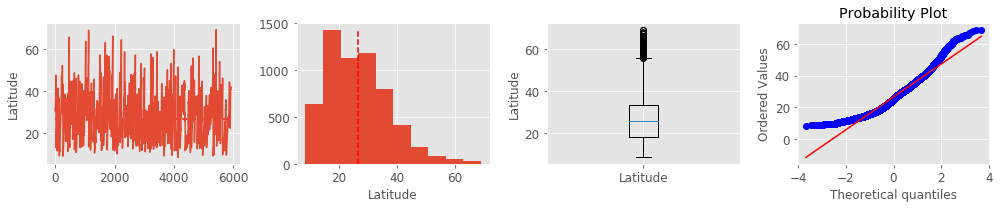

FEATURE: Longitude


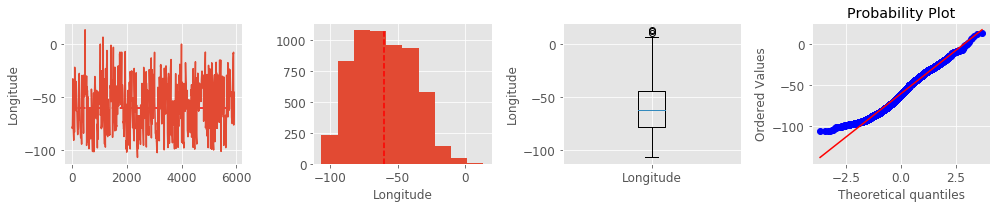

FEATURE: Low Wind SW


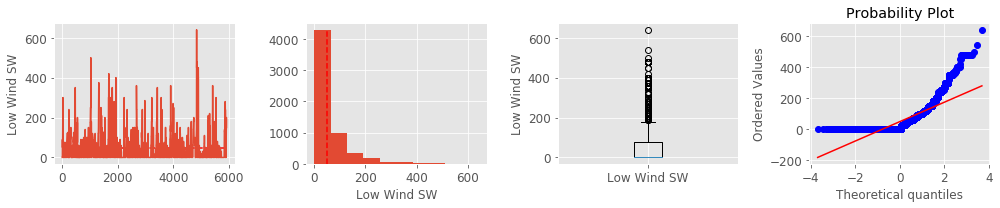

FEATURE: Moderate Wind NE


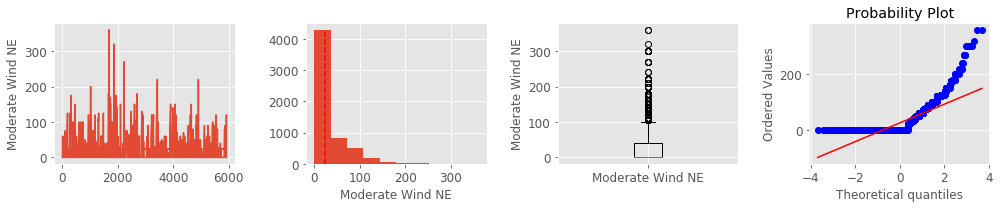

FEATURE: Moderate Wind SE


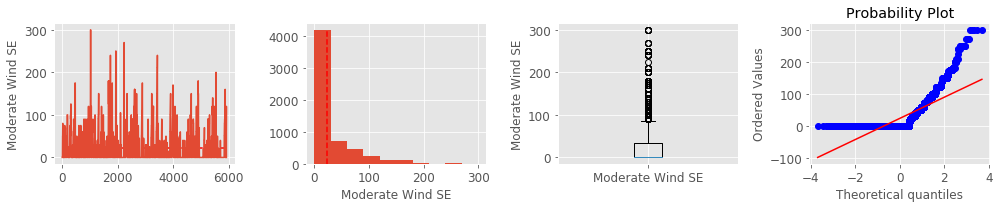

FEATURE: High Wind NW


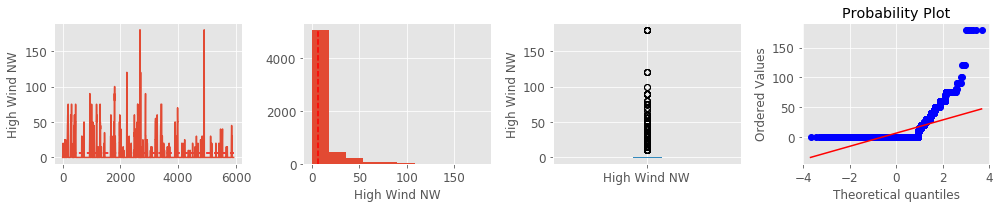

FEATURE: isTD


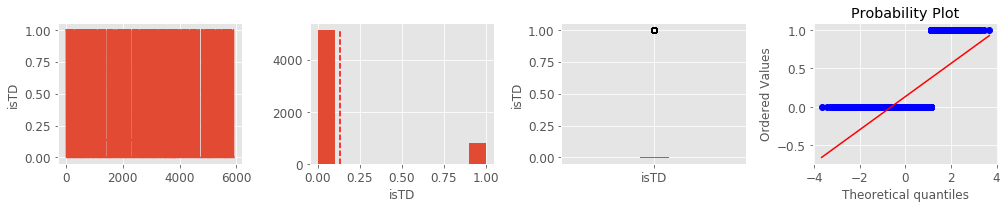

In [0]:
"""
Display the distributions of the data
use visualize.featureplots
to generate trace plots, histograms, boxplots, and probability plots for
each feature.

A probability plot is utilized to evaulate the normality of a distribution.
The data are plot against a theoritical distribution, such that if the data 
are normal, they'll follow the diagonal line. See the reference above for 
more information.
"""
cdata = processed_data.astype('float64').copy()
visualize.featureplots(cdata.values, cdata.columns)


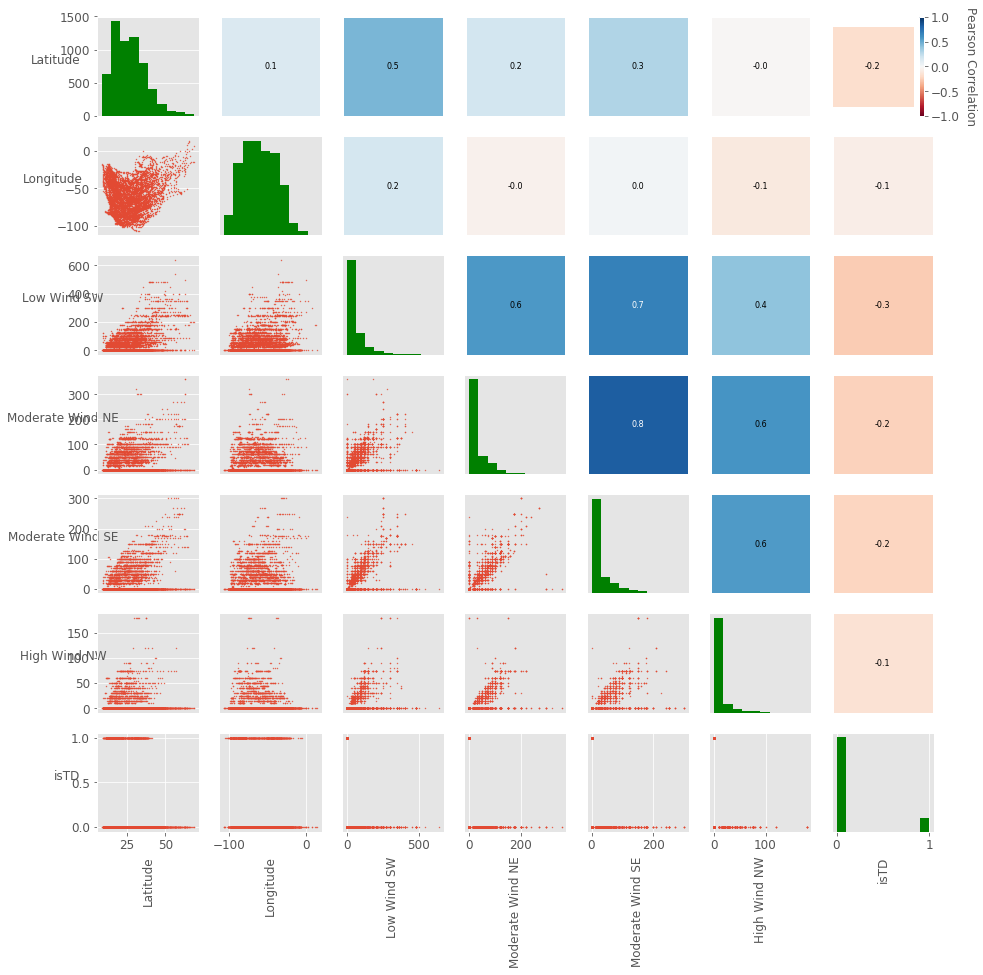

In [0]:
""" 
Display the Pearson correlation between all pairs of the features
using visualize.scatter_corrplots
"""
visualize.scatter_corrplots(cdata.values, cdata.columns, corrfmt="%.1f", FIGW=15)

In [0]:
"""
Extract the positive and negative cases
"""
# Get the positions of the positive and negative labeled examples
pos_inds = processed_data['isTD'] == 1
neg_inds = processed_data['isTD'] == 0

# Get the actual corresponding examples
pos = processed_data[pos_inds]
neg = processed_data[neg_inds]

# Positive Fraction
npos = pos_inds.sum()
nneg = nsamples - npos
pos_frac = npos / nsamples
neg_frac = 1 - pos_frac
(npos, pos_frac), (nneg, neg_frac)

((788, 0.13308562742779936), (5133, 0.8669143725722006))

# CLASSIFICATION

In [0]:
""" 
Functions for exporting trees to .dot and .pngs
"""
from PIL import Image
def image_combine(ntrees, big_name='big_tree.png', fname_fmt='tree_%02d.png'):
    '''
    Function for combining some of the trees in the forest into on image
    Amalgamate the pngs of the trees into one big image
    PARAMS:
        ntrees: number of trees from the ensemble to export
        big_name: file name for the png containing all ntrees
        fname_fmt: file name format string used to read the exported files
    '''
    # Read the pngs
    imgs = [Image.open(fname_fmt % x) for x in range(ntrees)]

    # Determine the individual and total sizes
    widths, heights = zip(*(i.size for i in imgs))
    total_width = sum(widths)
    max_height = max(heights)

    # Create the combined image
    big_img = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in imgs:
        big_img.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    big_img.save(big_name) 
    print("Created %s" % big_name)
    return big_img

def export_trees(forest, ntrees=3, fname_fmt='tree_%02d'):
    '''
    Write trees into inidividual files from the forest
    PARAMS:
        forest: ensemble of trees classifier
        ntrees: number of trees from the ensemble to export
        fname_fmt: file name format string used to name the exported files
    '''
    for t in range(ntrees):
        estimator = forest.estimators_[t]
        basename = fname_fmt % t
        fname = basename + '.dot'
        pngname = basename + '.png'
        export_graphviz(estimator, out_file=fname, rounded=True, filled=True)
        # Command line instruction to execute dot and create the image
        !dot -Tpng {fname} > {pngname}
        print("Created %s and %s" % (fname, pngname))


In [0]:
processed_data.columns

Index(['Latitude', 'Longitude', 'Low Wind SW', 'Moderate Wind NE',
       'Moderate Wind SE', 'High Wind NW', 'isTD'],
      dtype='object')

In [0]:
""" 
Split the data into X (i.e. the inputs) and y (i.e. the outputs).
Recall we are predicting isTD.

Hold out a subset of the data, before training and cross validation
using train_test_split, with stratification, and a test_size 
fraction of .2. See the sklearn API for more details

For this exploratory section, the held out set of data is a validation set.
"""
# Separate X and y. We are predicting isTD

X = processed_data.drop(['isTD'], axis=1)

Y = processed_data['isTD']


# Hold out 20% of the data for validation

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, stratify = Y)

x_train.shape,x_test.shape,y_train.shape,y_test.shape


((4736, 6), (1185, 6), (4736,), (1185,))

# DECISION TREE CLASSIFIER

In [0]:
""" 
Create and train DecisionTree for comparision with the ensemble methods 
"""
tree_clf = DecisionTreeClassifier(max_depth=200, max_leaf_nodes=10)
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=200,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

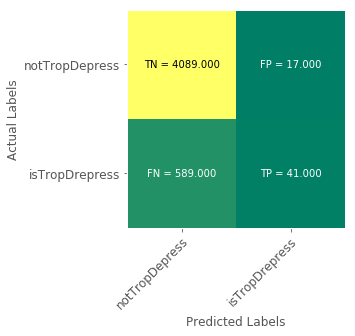

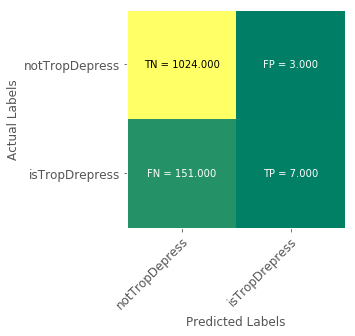

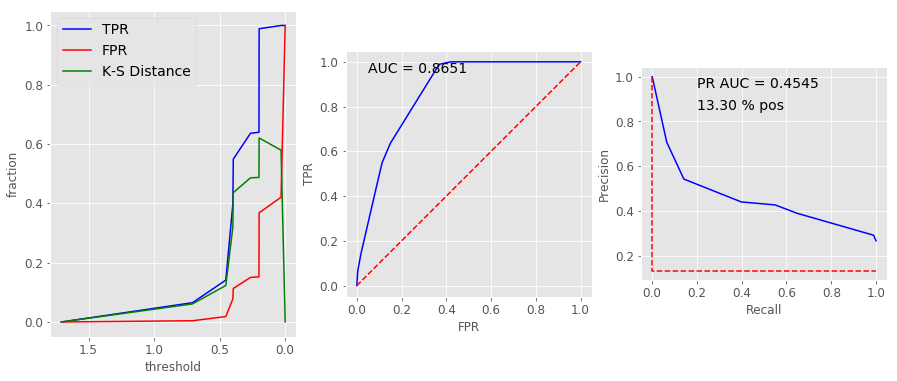

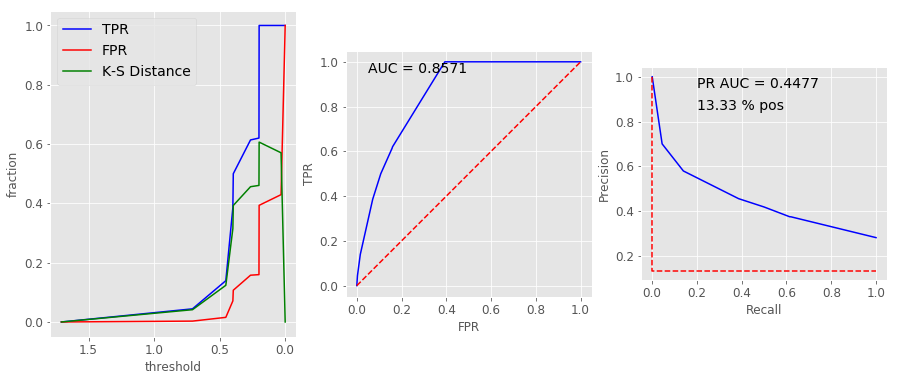

In [0]:
""" 
Compute the predictions, prediction probabilities, and the accuracy scores
for the trianing and validation sets
"""
# Compute the model's predictions
dt_preds = tree_clf.predict(x_train)
dt_preds_val = tree_clf.predict(x_test)

# Compute the prediction probabilities
dt_proba = tree_clf.predict_proba(x_train)
dt_proba_val = tree_clf.predict_proba(x_test)

# Compute the model's mean accuracy
dt_score = tree_clf.score(x_train, y_train) 
dt_score_val = tree_clf.score(x_test, y_test)

# Confusion Matrix
dt_cmtx = confusion_matrix(y_train, dt_preds)
dt_cmtx_val = confusion_matrix(y_test, dt_preds_val)
metrics_plots.confusion_mtx_colormap(dt_cmtx, targetnames, targetnames)
metrics_plots.confusion_mtx_colormap(dt_cmtx_val, targetnames, targetnames)

# KS, ROC, and PRC Curves
dt_roc_prc_results = metrics_plots.ks_roc_prc_plot(y_train, dt_proba[:,1])
dt_roc_prc_results_val = metrics_plots.ks_roc_prc_plot(y_test, dt_proba_val[:,1])

In [0]:
""" 
Export the tree as a .dot file and create the png
"""
fname = 'tree.dot'
pngname = 'tree.png'
export_graphviz(tree_clf, out_file=fname, rounded=True, filled=True)
!dot -Tpng {fname} > {pngname}

`![Best Model](tree.png)`
![tree](tree.png)

# RANDOM FOREST CLASSIFIER

In [0]:
""" 
Create and train RandomForests 
Explore various configurations of the hyper-parameters. 
Train the models on the training set and evaluate them for the training and
validation sets.
Take a look at the API and the book for the meaning and impact of different 
hyper-parameters
"""

forest_clf = RandomForestClassifier(n_estimators=100,max_leaf_nodes= 100,max_features = 0.1,bootstrap=True,
                                   n_jobs = -1)

forest_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
""" 
Export some trees from your favorite model as a .dot file
We can use the estimators_ attribute of the forest to get a list of the trees

Amalgamate the pngs of the trees into one big image
"""
ntrees = 2
export_trees(forest_clf, ntrees, fname_fmt='e_rf_model_%02d')
big_img = image_combine(ntrees, big_name='e_rf_model.png', 
                        fname_fmt='e_rf_model_%02d.png')

Created e_rf_model_00.dot and e_rf_model_00.png
Created e_rf_model_01.dot and e_rf_model_01.png
Created e_rf_model.png


![Forest](e_rf_model.png)

### TRAINING AND VALIDATION RESULTS

In [0]:
""" 
Compute the predictions, prediction probabilities, and the accuracy scores
for the training and validation sets for the learned instance of the model
"""
# Compute the model's predictions. use model.predict()

rf_preds = forest_clf.predict(x_train)
rf_preds_val = forest_clf.predict(x_test)


# Compute the prediction probabilities. use model.predict_proba()

rf_proba = forest_clf.predict_proba(x_train)
rf_proba_val = forest_clf.predict_proba(x_test)

# Compute the model's mean accuracy. use model.score()

rf_score = forest_clf.score(x_train, y_train) 
rf_score_val = forest_clf.score(x_test, y_test)

print(f"train score: {np.mean(rf_score)}, validation Score : {np.mean(rf_score_val)}")

train score: 0.9146959459459459, validation Score : 0.8717299578059071


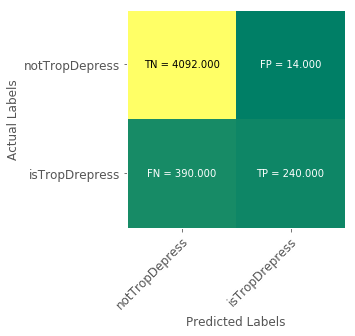

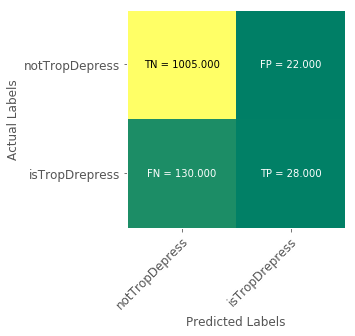

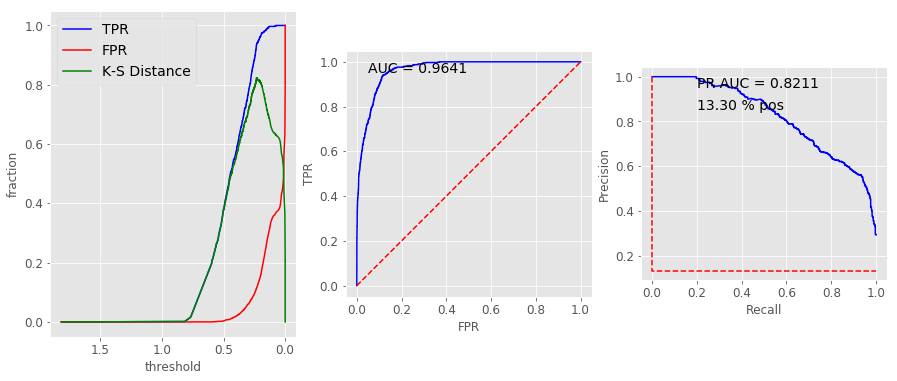

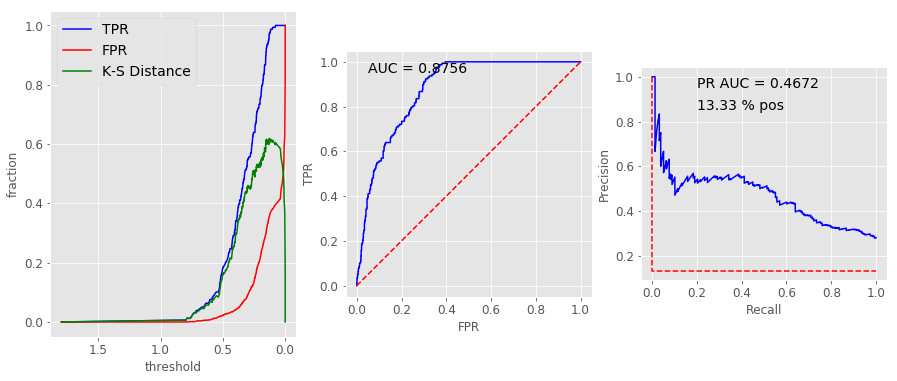

In [0]:
""" 
Display the confusion matrix, KS plot, ROC curve, and PR curve for the training 
and validation sets using metrics_plots.ks_roc_prc_plot

The red dashed line in the ROC and PR plots are indicative of the expected 
performance for a random classifier, which would predict postives at the 
rate of occurance within the data set
"""
# Confusion Matrix
rf_cmtx = confusion_matrix(y_train, rf_preds)
rf_cmtx_val = confusion_matrix(y_test, rf_preds_val)
metrics_plots.confusion_mtx_colormap(rf_cmtx, targetnames, targetnames)
metrics_plots.confusion_mtx_colormap(rf_cmtx_val, targetnames, targetnames)


# KS, ROC, and PRC Curves


rf_roc_prc_results = metrics_plots.ks_roc_prc_plot(y_train, rf_proba[:,1])


rf_roc_prc_results_val = metrics_plots.ks_roc_prc_plot(y_test, rf_proba_val[:,1])


# ADABOOSTING

In [0]:
""" 
Create and train a Boosting model 
Explore various boosting models to improve your validation performance
Train the models on the training set and evaluate them for the training and
validation sets. Try boosting the benmark tree_clf
"""

ada_clf = AdaBoostClassifier(tree_clf, n_estimators = 200, learning_rate=0.25)
ada_clf.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=200,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.25, n_estimators=200, random_state=None)

### TRAINING AND VALIDATION RESULTS

In [0]:
""" 
Compute the predictions, prediction probabilities, and the accuracy scores
for the trianing and validation sets
"""
#  Compute the model's predictions

ad_preds = ada_clf.predict(x_train)
ad_preds_val = ada_clf.predict(x_test)


# Compute the prediction probabilities 

ad_proba = ada_clf.predict_proba(x_train)
ad_proba_val = ada_clf.predict_proba(x_test)

# Compute the model's scores

ad_score = ada_clf.score(x_train, y_train) 
ad_score_val = ada_clf.score(x_test, y_test)

print(f"Ada_train score: {np.mean(ad_score)}, Ada_validation Score : {np.mean(ad_score_val)}")

Ada_train score: 0.9972550675675675, Ada_validation Score : 0.8438818565400844


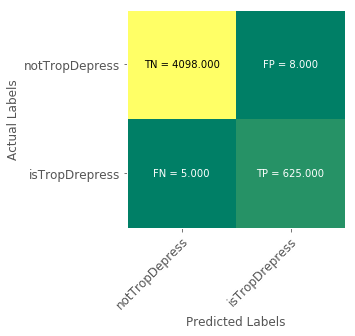

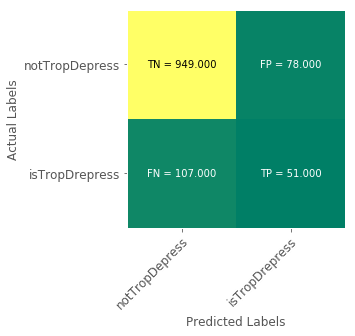

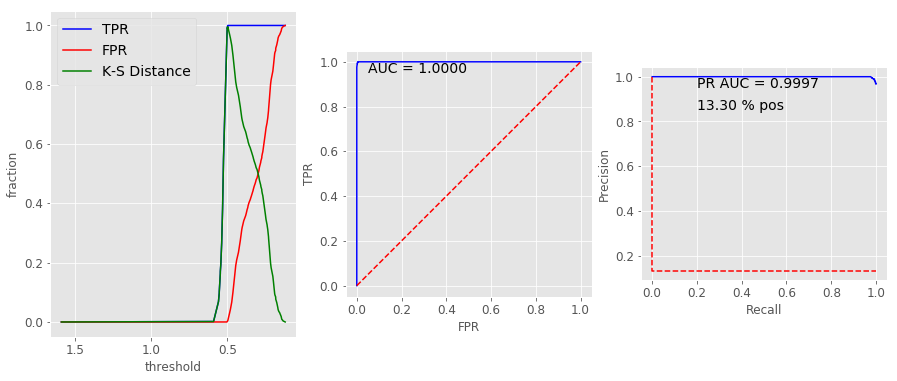

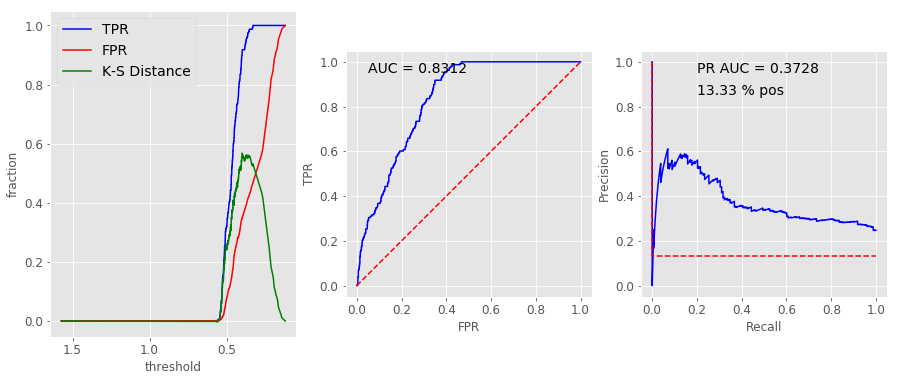

In [0]:
""" 
Display the confusion matrix, KS plot, ROC curve, and PR curve for the 
training and validation sets using metrics_plots.ks_roc_prc_plot
""" 
# Confusion Matrix

ad_cmtx = confusion_matrix(y_train, ad_preds)
ad_cmtx_val = confusion_matrix(y_test, ad_preds_val)
metrics_plots.confusion_mtx_colormap(ad_cmtx, targetnames, targetnames)
metrics_plots.confusion_mtx_colormap(ad_cmtx_val, targetnames, targetnames)


# KS, ROC, and PRC Curves

ad_roc_prc_results = metrics_plots.ks_roc_prc_plot(y_train, ad_proba[:,1])
ad_roc_prc_results_val = metrics_plots.ks_roc_prc_plot(y_test, ad_proba_val[:,1])


In [0]:
x_train.columns

Index(['Latitude', 'Longitude', 'Low Wind SW', 'Moderate Wind NE',
       'Moderate Wind SE', 'High Wind NW'],
      dtype='object')

# FEATURE IMPORTANCE

In [0]:
""" 
Display the feature imporantances
see the API for RandomForests and boosted tree
you can create a DataFrame to help with the display
"""


importances_rf = forest_clf.feature_importances_


rt_feature_importances = pd.DataFrame(importances_rf, index = x_train.columns).sort_values(0, ascending=False)

print("Feature ranking:")


print(rt_feature_importances)

Feature ranking:
                         0
Latitude          0.343032
Longitude         0.341822
Low Wind SW       0.176341
Moderate Wind NE  0.070744
Moderate Wind SE  0.048492
High Wind NW      0.019569


In [0]:
importances_ada = ada_clf.feature_importances_

ada_feature_importances = pd.DataFrame(importances_ada, index = x_train.columns).sort_values(0, ascending=False)

print("Feature ranking:")

print(ada_feature_importances)

Feature ranking:
                         0
Longitude         0.553081
Latitude          0.427514
Low Wind SW       0.015354
Moderate Wind NE  0.003188
Moderate Wind SE  0.000863
High Wind NW      0.000000


# DISCUSSION


### Interpreting the results for the RandomForestClassifier

Random Forest Classifiers performs pretty good on both my train and validation data. I have got mean scores close to 0.90 which is good.

Results on Traing Data:

My Model gives me an ROC AUC curve area to be 0.9626 and PR auc curve area to be 0.8083. This is evident that I have more Negative values in my data, that was the reason my model was able to predict most of the negative values which gave me higher ROC area, while having 0.8080 for PR AUC shows that my model does predict decent number of Positive values which is good as far as Training data is Considered.

Results on Testing Data:
Model gives me ROC AUC value to be 0.9011 and PR AUC to be 0.5561. These are for my validation data. I can see that My model predicts good number of negative values which gave us good ROC AUC value, but coming to the positive values model could have performed better,having 0.5561 shows that it is not doing well eith prediction of positive values.

#### Meaning in terms of the context of predicting tropical depressions and the potential impact of various features.

As per the context of Predicting Tropical Depressions, My model does good job in predicting when there is no tropical Depression, but it does not do a proper job in predicting when there is a tropical depression.

And checking the Feature Importances,we can see that Latititude, Longitude and Low Wind SW, impacts our model significantly. If we have changes to these values, the prediction is impacted multi foldes and we might get varied predictions. Latitude and longitude are having similar importances, so when we consider our random forest model taking proper values of these features gives us better results.


### Selection of hyper parameters and Describing how performance changes over the hyper-parameter space.

RandomForestClassifier(n_estimators=100,max_leaf_nodes= 100,max_features = 0.1,bootstrap=True,
                                   n_jobs = -1)

Coming to the Hyperparameters I have selected number of trees in the forest, n_estimators to be equal to 100, which worked better on the data, I tried different range of values, but having a value of 100 worked just fine!!

I have given the hyper parameter that grow trees with 100 leaf nodes. These are defined as a relative reduction in Impurity.

I have given a fraction value for Max_feaures which is multiplied by number of features wand that number of fetures are considered while considering best split.

Keeping Bootstrap as True gave me better results than Keeping it false, which makes whole dataset to be used while building each tree, Hyper paramters are defining my model, having better hyperparameters gave me better results.


## Describing the impact of boosting

I could see that my Ada-Boost Model performs really well on my training data, I get better results fot both ROC AU and PR AUC values. I guess the data i gave for training must have included some patterns that are not linear. Swiching to AdaBoost allows us to capture many of htese non- linear relationships which translated into better predictions of both Positve and negative examples.

But This was not the same with Validation data, Surprisingly the results were bad when compared to Random Forest Model. I think this is case of overfitting where model is performing really well on trianing data while it is not that good on validation data. Boosting did not have much impact on my validation data,we can use the Random forest model Instead. Checking the feature importances, I get to see Longitude having the highest importance, which shoes that the prediction of tropical depression is influenced by Longitude, and Latitude, while other features are not impacting the prediction much. Infact even if we remove High Wind NW , our results might not vary much as this feature is not at all impacting the prediction.